In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.optimizers import Adam
import nltk
from nltk.corpus import stopwords

# Load datasets
df_2021 = pd.read_csv("/content/amazon_reviews_2021.csv")
df_2023 = pd.read_csv("/content/amazon_reviews_2023.csv")

In [3]:
# Filter for a specific retailer
specific_retailer = "SanDisk"
df_2021 = df_2021[df_2021['reviewText'].str.contains(specific_retailer, case=False)]
df_2023 = df_2023[df_2023['reviewText'].str.contains(specific_retailer, case=False)]

In [4]:
df_2021.head(15)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
3,3,S. Power,1,"Love Sandisk, never had a problem with them an...",05/01/2021,377,14,44,58,-30,3.247631,1.783855
18,18,"rtrski ""Who, me?""",3,failed in my galaxy note after 8 months.lost a...,12/06/2021,445,4,44,48,-40,4.931815,4.471414
23,23,M. Harwell,5,SanDisk never disappoints. As always SanDisk p...,11/25/2021,530,46,47,93,-1,3.605105,4.815927
32,32,D. Crider,3,"If you want tons of capacity, here it is. Bou...",01/27/2021,862,2,18,20,-16,0.394245,1.742659
39,39,Claudia Barclay,4,Have always had good experiences with SanDisk ...,09/02/2021,836,35,37,72,-2,0.869739,1.394827
53,53,"Denny Crane, Esq.",1,I have always been satisfied with sandisk prod...,11/02/2021,741,9,17,26,-8,2.914765,1.708512
54,54,Austin,4,Never had a failure with SanDisk like other mf...,06/04/2021,86,40,43,83,-3,0.347608,1.384948
56,56,"Gary A. Creighton ""Gary A. Creighton""",3,"The moment I got this, I just plugged it into ...",09/25/2021,320,12,17,29,-5,0.305614,3.194389
64,64,jmachado,4,I really like these SanDisk Ultra microSDHC Cl...,12/19/2021,525,18,1,19,17,3.594320,1.776518
72,72,rpgmaker,4,I only ever use SanDisk and have never had a p...,08/01/2021,256,32,19,51,13,2.419307,0.835368


In [5]:
df_2023.head(15)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
4,4,Joshua J. Wagner,1,To be the man you gotta beat the man brotha. A...,04/26/2023,108,38,48,86,-10,1.326933,2.231435
6,6,Robert Poole,5,I got the 16GB card for my Garmin GPS. The GPS...,12/29/2023,540,36,4,40,32,2.520394,1.987002
7,7,odaddio,5,I bought this for my Samsung galaxy s4. I don'...,03/03/2023,439,43,36,79,7,4.540217,1.410229
11,11,The J Train,1,64 GB additional memory for a great low price....,01/23/2023,666,21,25,46,-4,2.113602,1.193307
25,25,Sujith Nair,4,The description on the Amazon page calls this ...,09/20/2023,343,4,47,51,-43,3.811626,4.567224
28,28,Shaun Kanak,4,SanDisk is well known for their microsd cards....,12/06/2023,849,2,34,36,-32,3.518514,0.736103
29,29,Elchis,3,SanDisk chips are pretty good but relatively e...,06/28/2023,301,41,8,49,33,0.166703,0.782466
42,42,Troy N.Stennett,2,64 GB on a micro-SD card ... that itself was a...,07/14/2023,893,47,23,70,24,3.073082,0.617047
47,47,"Marcio Barbosa Matielo ""mizifih""",5,Sandisk has the name but in my experience the ...,09/14/2023,601,32,40,72,-8,0.066176,0.578017
51,51,Lauren Glenn,4,I have always been pleased with the SanDisk pr...,08/23/2023,329,0,41,41,-41,1.891241,1.503161


In [6]:
# Clean text
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert text to lowercase
    return text

df_2021['reviewText_cleaned'] = df_2021['reviewText'].apply(clean_text)
df_2023['reviewText_cleaned'] = df_2023['reviewText'].apply(clean_text)

# Sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df_2021['sentiment'] = df_2021['reviewText_cleaned'].apply(get_sentiment)
df_2023['sentiment'] = df_2023['reviewText_cleaned'].apply(get_sentiment)

# Calculate review length
df_2021['review_length'] = df_2021['reviewText'].apply(len)
df_2023['review_length'] = df_2023['reviewText'].apply(len)


<ipython-input-7-98419604111c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='sentiment_category', y='review_length', data=df_2021, palette='Set2')
<ipython-input-7-98419604111c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='sentiment_category', y='review_length', data=df_2023, palette='Set3')


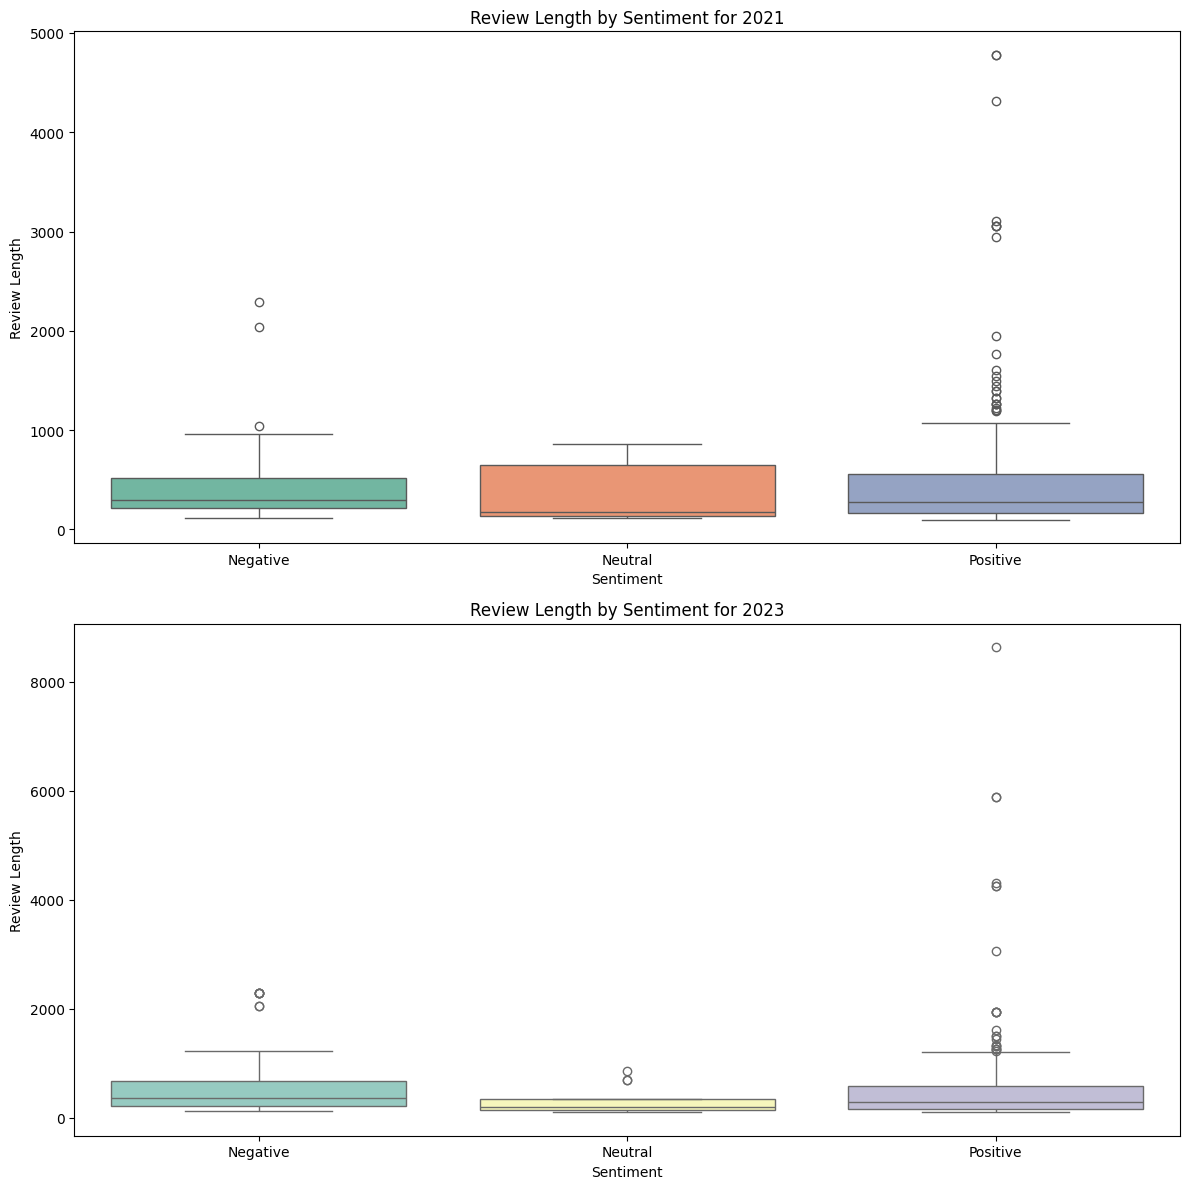

In [7]:
# Ensure you exclude NaN values
df_2021 = df_2021.dropna(subset=['sentiment', 'review_length'])
df_2023 = df_2023.dropna(subset=['sentiment', 'review_length'])

# Convert sentiment to categorical
df_2021['sentiment_category'] = pd.cut(df_2021['sentiment'], bins=[-1, -0.01, 0.01, 1], labels=['Negative', 'Neutral', 'Positive'])
df_2023['sentiment_category'] = pd.cut(df_2023['sentiment'], bins=[-1, -0.01, 0.01, 1], labels=['Negative', 'Neutral', 'Positive'])

# Plot review length by sentiment for 2021 and 2023 with improved visualization
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

sns.boxplot(ax=axes[0], x='sentiment_category', y='review_length', data=df_2021, palette='Set2')
axes[0].set_title('Review Length by Sentiment for 2021')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Review Length')

sns.boxplot(ax=axes[1], x='sentiment_category', y='review_length', data=df_2023, palette='Set3')
axes[1].set_title('Review Length by Sentiment for 2023')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Review Length')

plt.tight_layout()
plt.show()


In [8]:
# Summary statistics
summary_2021 = df_2021.describe()
summary_2023 = df_2023.describe()

print("Summary Statistics for 2021:")
print(summary_2021)
print("\nSummary Statistics for 2023:")
print(summary_2023)



Summary Statistics for 2021:
        Unnamed: 0     overall    day_diff  helpful_yes  helpful_no  \
count   514.000000  514.000000  514.000000   514.000000  514.000000   
mean   1363.844358    3.145914  498.429961    24.412451   23.295720   
std     750.503859    1.355126  285.480430    14.840448   14.452116   
min       3.000000    1.000000    5.000000     0.000000    0.000000   
25%     755.000000    2.000000  249.250000    12.000000   11.000000   
50%    1354.500000    3.000000  503.000000    23.000000   22.000000   
75%    1995.250000    4.000000  737.750000    38.000000   35.000000   
max    2677.000000    5.000000  997.000000    49.000000   49.000000   

       total_vote  score_pos_neg_diff  score_average_rating  \
count  514.000000          514.000000            514.000000   
mean    47.708171            1.116732              2.350713   
std     20.646955           20.782405              1.475687   
min      1.000000          -47.000000              0.000593   
25%     33.00000

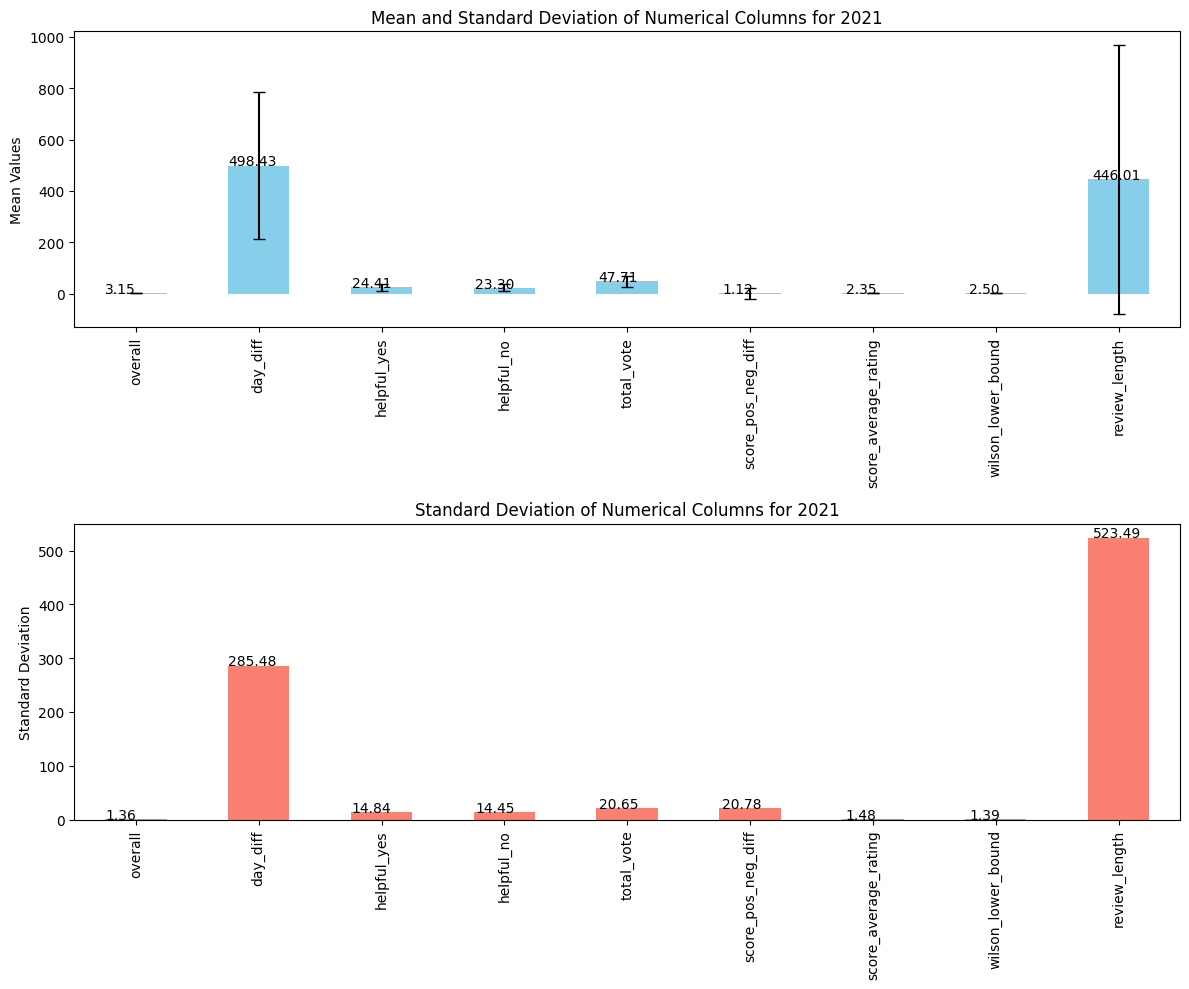

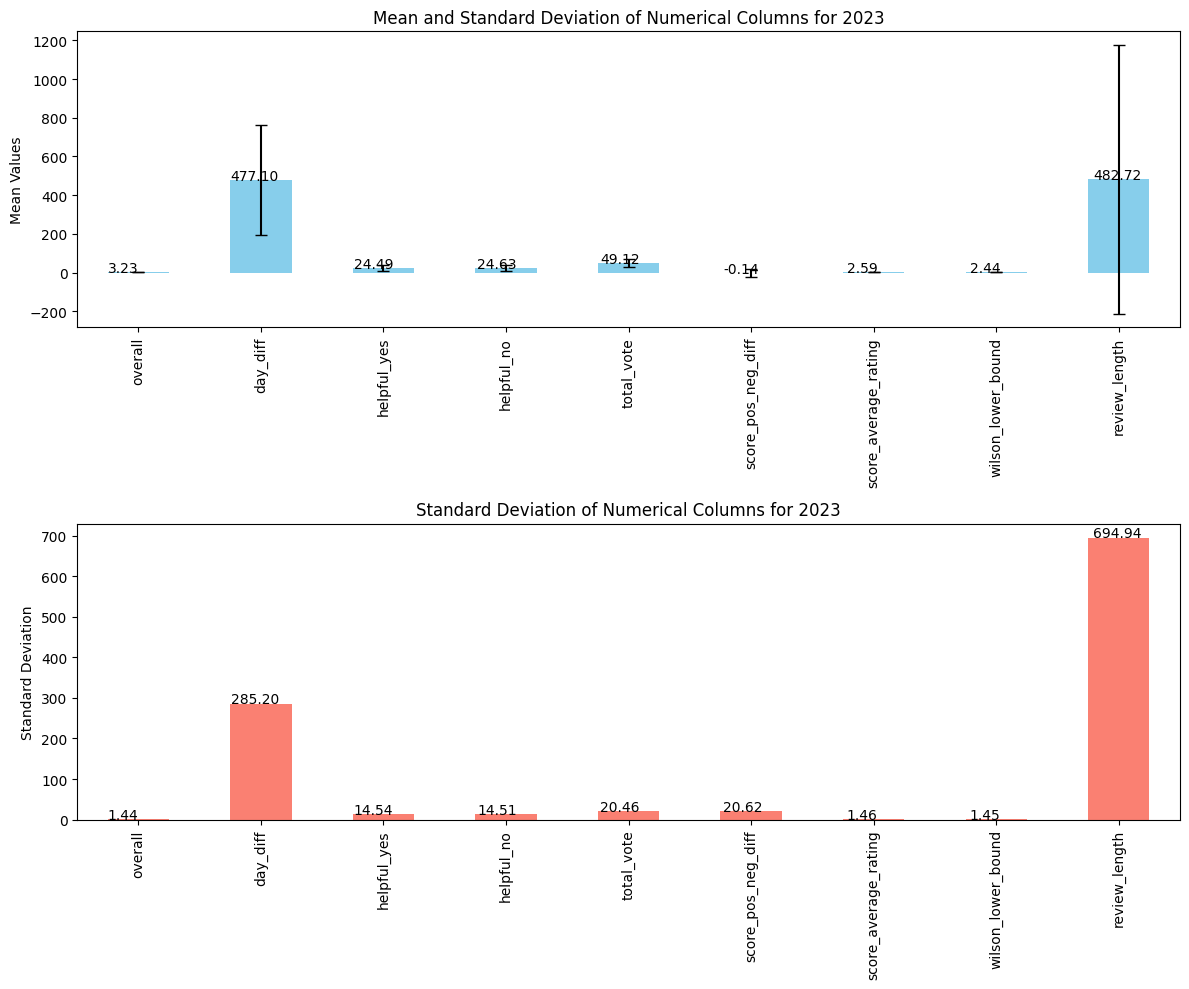

In [9]:
# Graphical summary statistics
numeric_columns = ['overall', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
                   'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound', 'review_length']

def plot_summary_statistics(df, year):
    means = df[numeric_columns].mean()
    stds = df[numeric_columns].std()

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    means.plot(kind='bar', ax=axes[0], color='skyblue', yerr=stds, capsize=4)
    axes[0].set_title(f'Mean and Standard Deviation of Numerical Columns for {year}')
    axes[0].set_ylabel('Mean Values')
    for p in axes[0].patches:
        axes[0].annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))

    stds.plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title(f'Standard Deviation of Numerical Columns for {year}')
    axes[1].set_ylabel('Standard Deviation')
    for p in axes[1].patches:
        axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.tight_layout()
    plt.show()

plot_summary_statistics(df_2021, '2021')
plot_summary_statistics(df_2023, '2023')

In [10]:
# Check for missing values
print("Missing Values for 2021:")
print(df_2021.isnull().sum())
print("\nMissing Values for 2023:")
print(df_2023.isnull().sum())


Missing Values for 2021:
Unnamed: 0              0
reviewerName            0
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
reviewText_cleaned      0
sentiment               0
review_length           0
sentiment_category      0
dtype: int64

Missing Values for 2023:
Unnamed: 0              0
reviewerName            0
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
reviewText_cleaned      0
sentiment               0
review_length           0
sentiment_category      0
dtype: int64


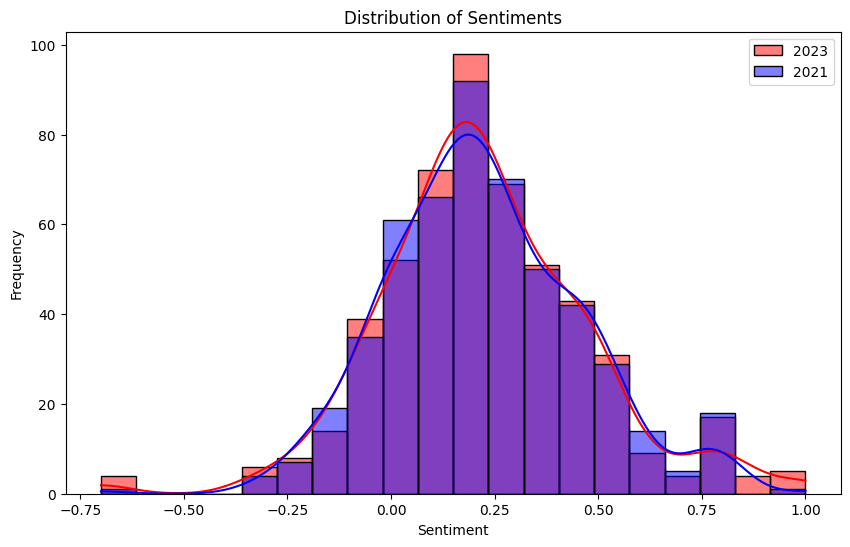

In [11]:
# Distribution of sentiments
plt.figure(figsize=(10, 6))
sns.histplot(data=df_2023, x='sentiment', bins=20, kde=True, color='red', label='2023')
sns.histplot(data=df_2021, x='sentiment', bins=20, kde=True, color='blue', label='2021')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.show()


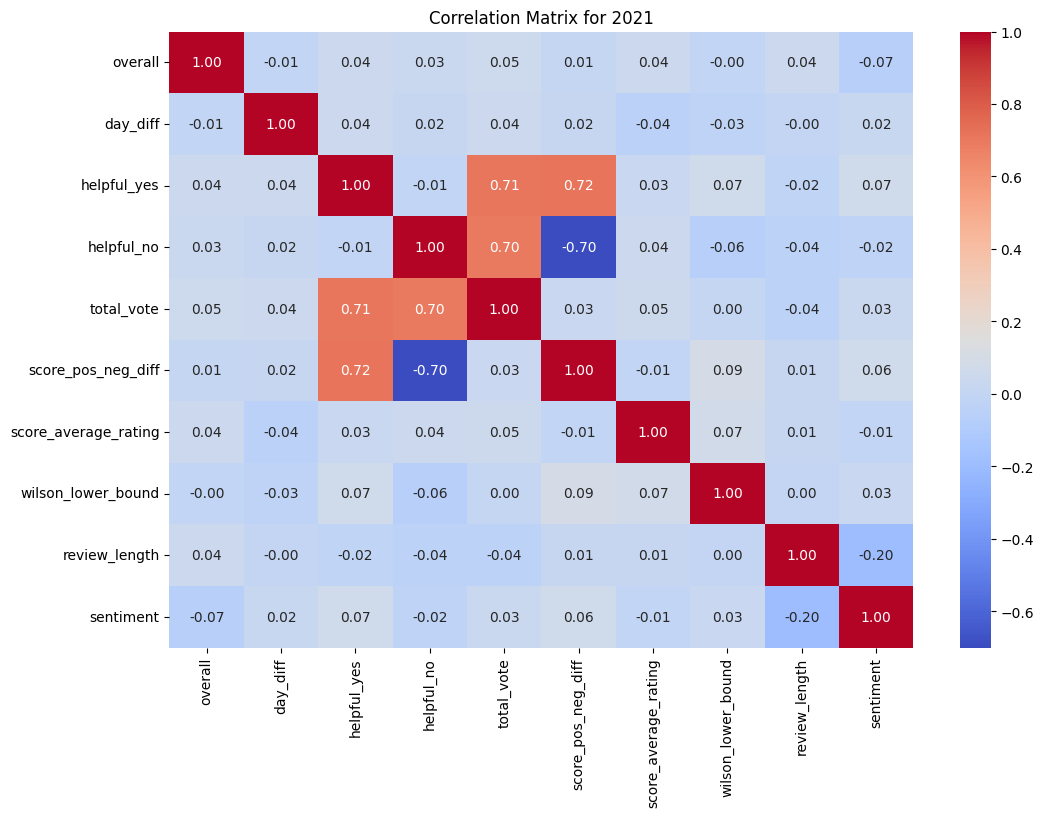

In [12]:
# Correlation for 2021
correlation_matrix_2021 = df_2021[['overall', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound', 'review_length', 'sentiment']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_2021, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for 2021')
plt.show()


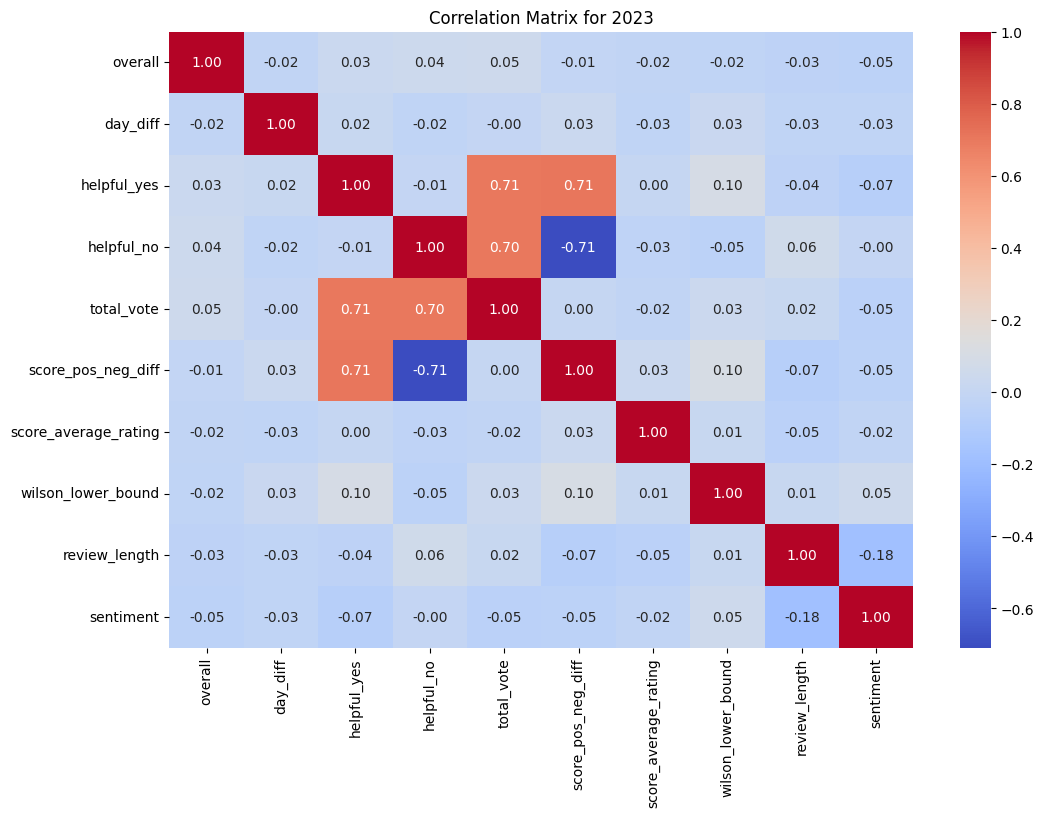

In [13]:
# Correlation for 2023
correlation_matrix_2023 = df_2023[['overall', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound', 'review_length', 'sentiment']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_2023, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for 2023')
plt.show()


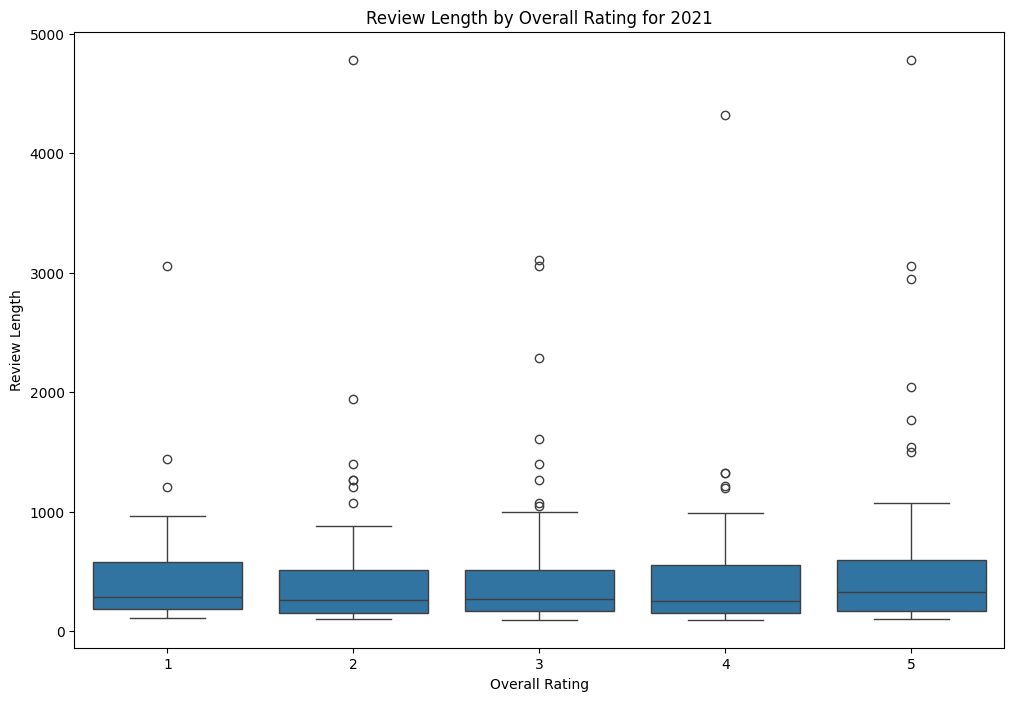

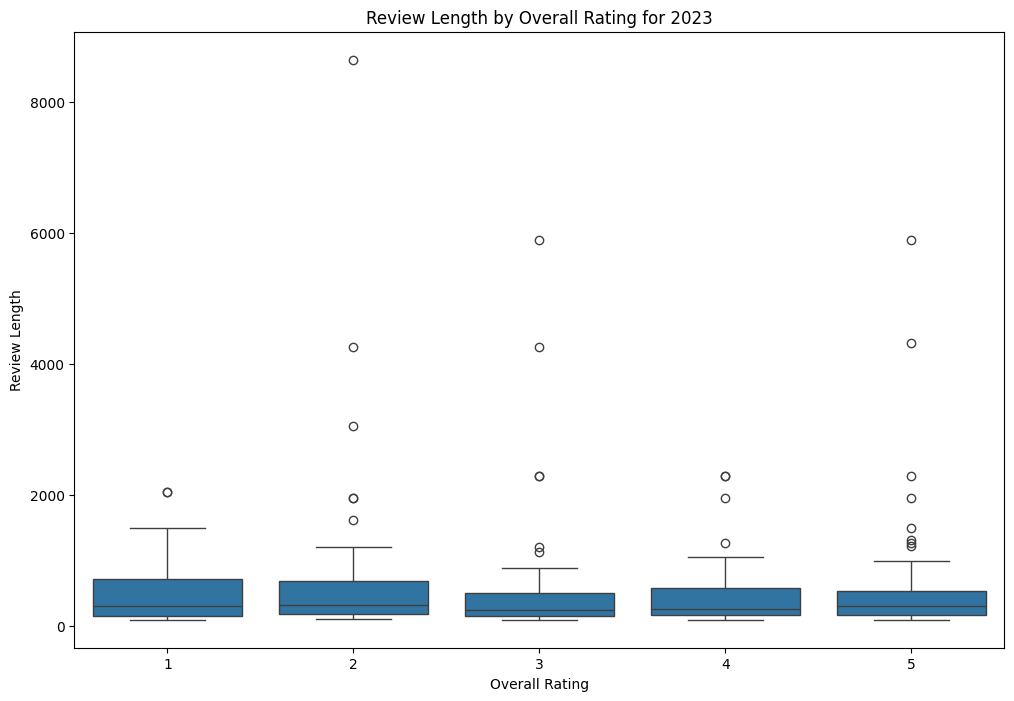

In [14]:
# Box plots for 2021
plt.figure(figsize=(12, 8))
sns.boxplot(x='overall', y='review_length', data=df_2021)
plt.title('Review Length by Overall Rating for 2021')
plt.xlabel('Overall Rating')
plt.ylabel('Review Length')
plt.show()

# Box plots for 2023
plt.figure(figsize=(12, 8))
sns.boxplot(x='overall', y='review_length', data=df_2023)
plt.title('Review Length by Overall Rating for 2023')
plt.xlabel('Overall Rating')
plt.ylabel('Review Length')
plt.show()


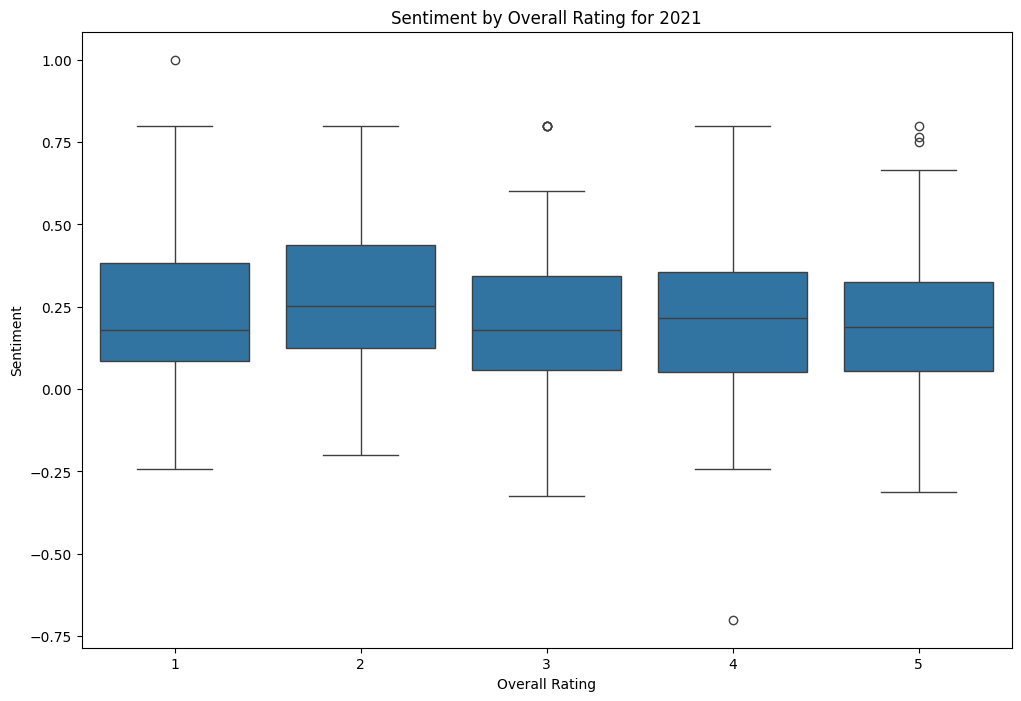

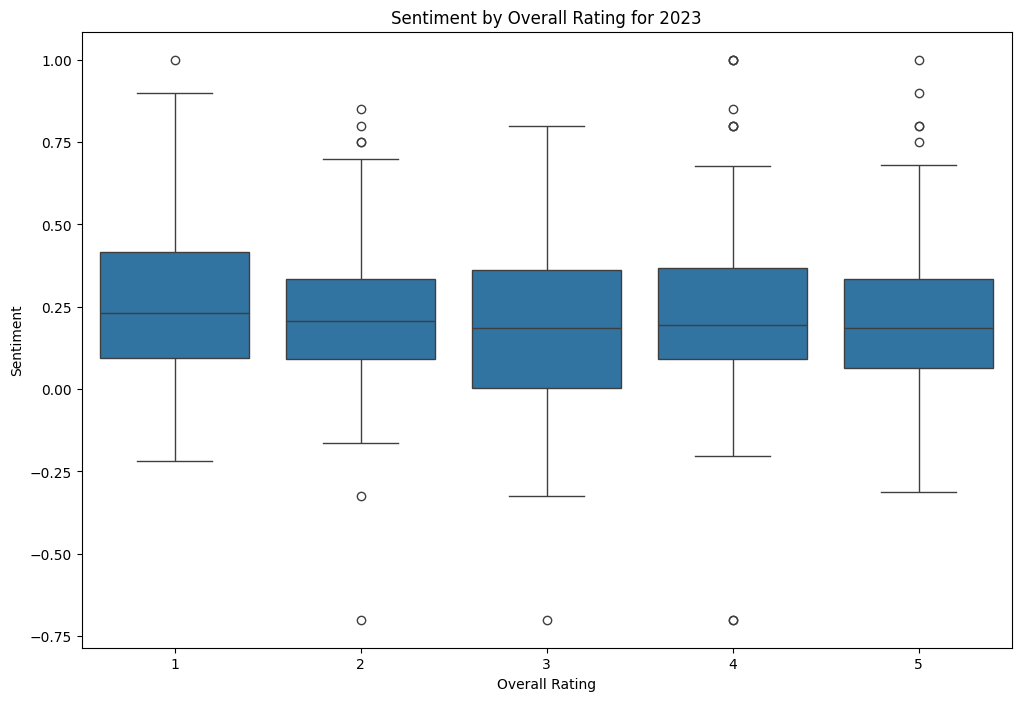

In [15]:
# Outliers for 2021
plt.figure(figsize=(12, 8))
sns.boxplot(x='overall', y='sentiment', data=df_2021)
plt.title('Sentiment by Overall Rating for 2021')
plt.xlabel('Overall Rating')
plt.ylabel('Sentiment')
plt.show()

# Outliers for 2023
plt.figure(figsize=(12, 8))
sns.boxplot(x='overall', y='sentiment', data=df_2023)
plt.title('Sentiment by Overall Rating for 2023')
plt.xlabel('Overall Rating')
plt.ylabel('Sentiment')
plt.show()

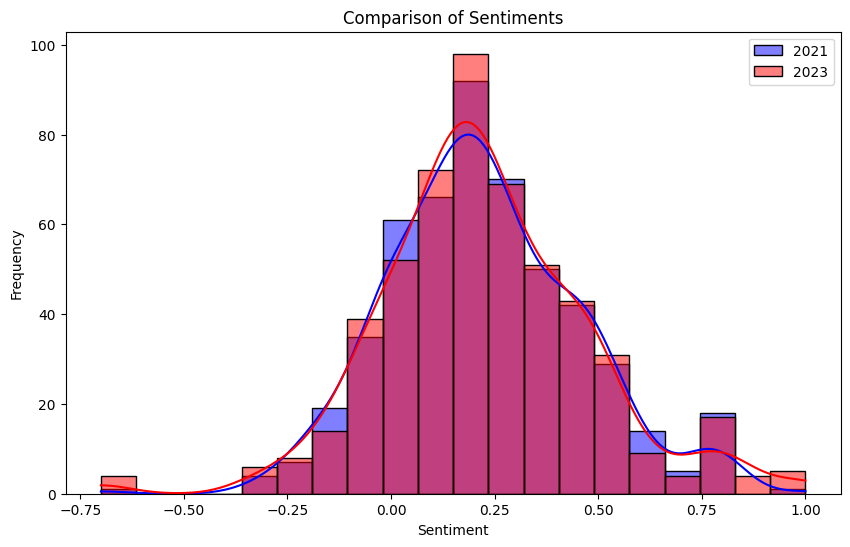

In [16]:

# Comparison of sentiments from both years
plt.figure(figsize=(10, 6))
sns.histplot(data=df_2021, x='sentiment', bins=20, kde=True, color='blue', label='2021')
sns.histplot(data=df_2023, x='sentiment', bins=20, kde=True, color='red', label='2023')
plt.title('Comparison of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')

# Combine the datasets for a larger sample size
df_combined = pd.concat([df_2021[['reviewText_cleaned', 'sentiment']], df_2023[['reviewText_cleaned', 'sentiment']]])

# Convert sentiment to a binary classification problem
df_combined['sentiment_label'] = np.where(df_combined['sentiment'] > 0, 1, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combined['reviewText_cleaned'], df_combined['sentiment_label'], test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Logistic Regression**

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following er

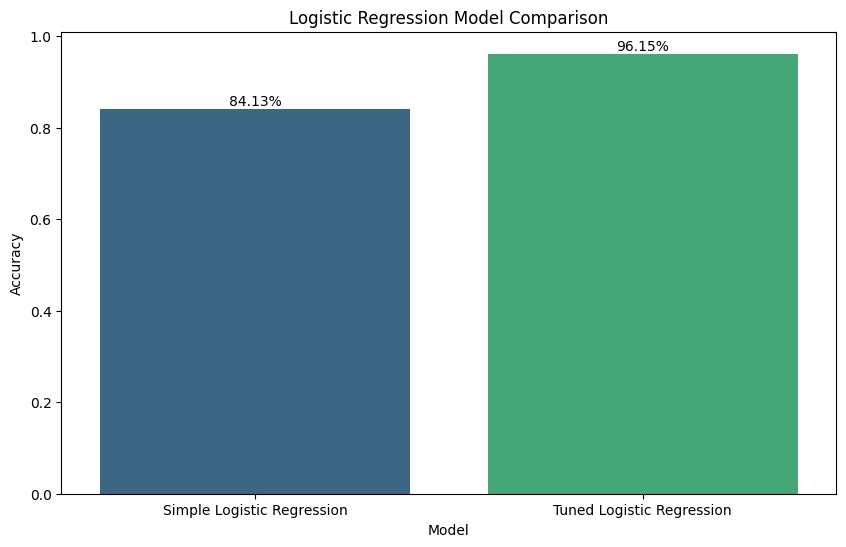

The best Logistic Regression model is Tuned Logistic Regression with an accuracy of 96.15%


In [18]:
# Simple Logistic Regression
log_reg_simple = LogisticRegression(max_iter=1000)
log_reg_simple.fit(X_train_tfidf, y_train)
log_reg_simple_pred = log_reg_simple.predict(X_test_tfidf)
log_reg_simple_acc = accuracy_score(y_test, log_reg_simple_pred)

# Hyperparameter Tuning for Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': [None, 'balanced']
}
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy', n_jobs=-1)
log_reg_grid.fit(X_train_tfidf, y_train)
log_reg_best = log_reg_grid.best_estimator_
log_reg_best_pred = log_reg_best.predict(X_test_tfidf)
log_reg_best_acc = accuracy_score(y_test, log_reg_best_pred)

# Compare results
results = {
    'Simple Logistic Regression': log_reg_simple_acc,
    'Tuned Logistic Regression': log_reg_best_acc
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')
plt.title('Logistic Regression Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for index, value in enumerate(results_df['Accuracy']):
    plt.text(index, value, f'{value*100:.2f}%', ha='center', va='bottom')
plt.show()

# Display the best Logistic Regression model
best_log_reg_model = results_df['Accuracy'].idxmax()
print(f"The best Logistic Regression model is {best_log_reg_model} with an accuracy of {results[best_log_reg_model]*100:.2f}%")

**SVM**

<ipython-input-19-27d1a8f9494c>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')


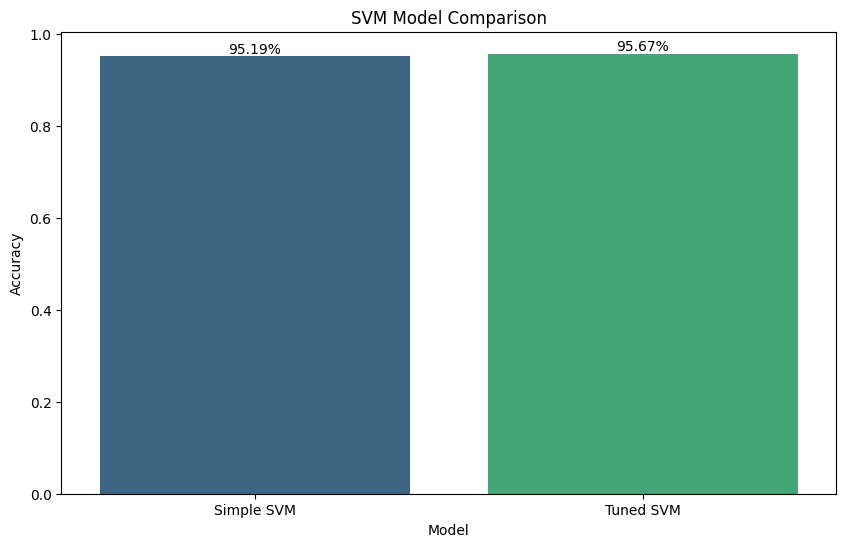

The best SVM model is Tuned SVM with an accuracy of 95.67%


In [19]:
# Simple SVM
svm_simple = SVC()
svm_simple.fit(X_train_tfidf, y_train)
svm_simple_pred = svm_simple.predict(X_test_tfidf)
svm_simple_acc = accuracy_score(y_test, svm_simple_pred)


# Hyperparameter Tuning for SVM
svm = SVC()
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_tfidf, y_train)
svm_best = svm_grid.best_estimator_
svm_best_pred = svm_best.predict(X_test_tfidf)
svm_best_acc = accuracy_score(y_test, svm_best_pred)


# Compare results
results = {
    'Simple SVM': svm_simple_acc,
    'Tuned SVM': svm_best_acc
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')
plt.title('SVM Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for index, value in enumerate(results_df['Accuracy']):
    plt.text(index, value, f'{value*100:.2f}%', ha='center', va='bottom')
plt.show()

# Display the best SVM model
best_svm_model = results_df['Accuracy'].idxmax()
print(f"The best SVM model is {best_svm_model} with an accuracy of {results[best_svm_model]*100:.2f}%")


**Random Forest**

<ipython-input-20-dd24953c9c30>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')


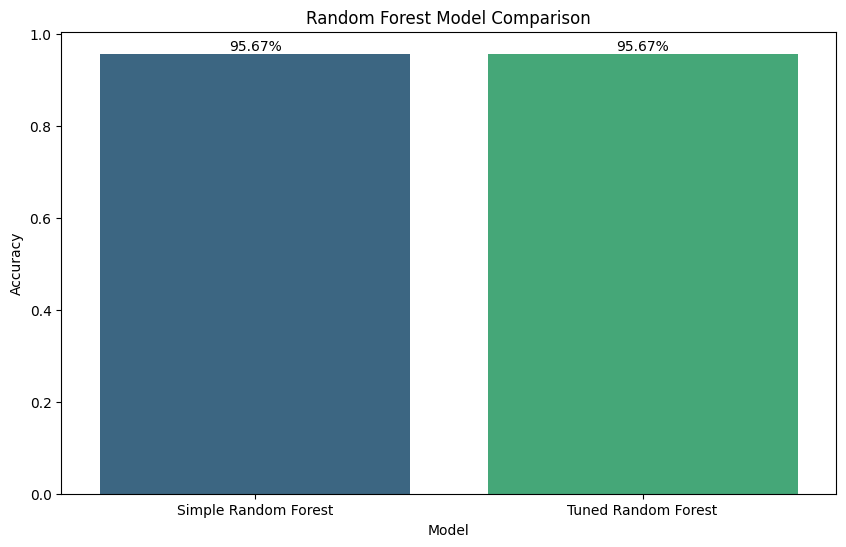

The best Random Forest model is Simple Random Forest with an accuracy of 95.67%


In [20]:
# Simple Random Forest
rf_simple = RandomForestClassifier()
rf_simple.fit(X_train_tfidf, y_train)
rf_simple_pred = rf_simple.predict(X_test_tfidf)
rf_simple_acc = accuracy_score(y_test, rf_simple_pred)

# Hyperparameter Tuning for Random Forest
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_tfidf, y_train)
rf_best = rf_grid.best_estimator_
rf_best_pred = rf_best.predict(X_test_tfidf)
rf_best_acc = accuracy_score(y_test, rf_best_pred)

# Compare results
results = {
    'Simple Random Forest': rf_simple_acc,
    'Tuned Random Forest': rf_best_acc
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')
plt.title('Random Forest Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for index, value in enumerate(results_df['Accuracy']):
    plt.text(index, value, f'{value*100:.2f}%', ha='center', va='bottom')
plt.show()

# Display the best Random Forest model
best_rf_model = results_df['Accuracy'].idxmax()
print(f"The best Random Forest model is {best_rf_model} with an accuracy of {results[best_rf_model]*100:.2f}%")


Epoch 1/100
12/12 - 8s - loss: 0.5917 - accuracy: 0.8075 - val_loss: 0.7525 - val_accuracy: 0.7381 - 8s/epoch - 655ms/step
Epoch 2/100
12/12 - 6s - loss: 0.4218 - accuracy: 0.8422 - val_loss: 0.5757 - val_accuracy: 0.7381 - 6s/epoch - 505ms/step
Epoch 3/100
12/12 - 4s - loss: 0.3762 - accuracy: 0.8489 - val_loss: 0.5353 - val_accuracy: 0.7381 - 4s/epoch - 357ms/step
Epoch 4/100
12/12 - 4s - loss: 0.2907 - accuracy: 0.8610 - val_loss: 0.4571 - val_accuracy: 0.7619 - 4s/epoch - 340ms/step
Epoch 5/100
12/12 - 6s - loss: 0.1662 - accuracy: 0.9398 - val_loss: 0.2999 - val_accuracy: 0.9286 - 6s/epoch - 481ms/step
Epoch 6/100
12/12 - 4s - loss: 0.0904 - accuracy: 0.9853 - val_loss: 0.2752 - val_accuracy: 0.9405 - 4s/epoch - 372ms/step
Epoch 7/100
12/12 - 4s - loss: 0.0495 - accuracy: 0.9960 - val_loss: 0.2636 - val_accuracy: 0.9286 - 4s/epoch - 340ms/step
Epoch 8/100
12/12 - 6s - loss: 0.0238 - accuracy: 0.9960 - val_loss: 0.2756 - val_accuracy: 0.9048 - 6s/epoch - 467ms/step
Epoch 9/100
12/1

<ipython-input-21-2a1c8f9d3d5f>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')


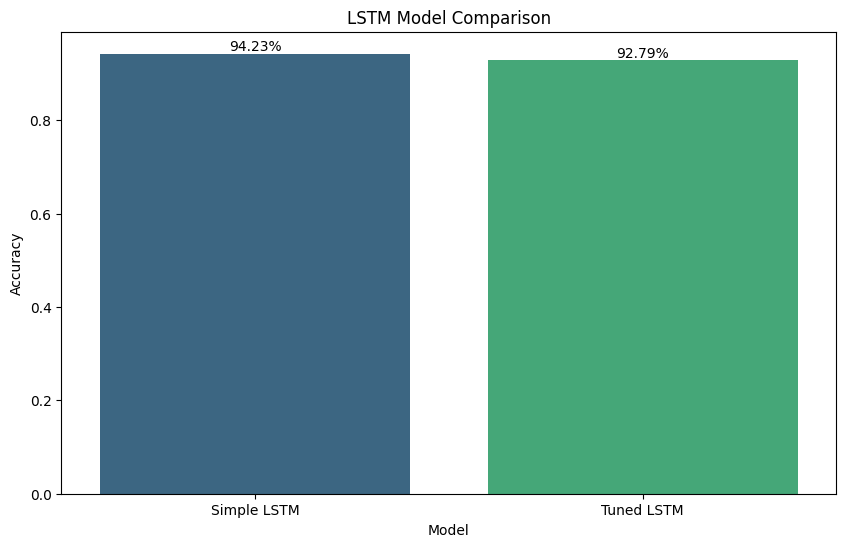

The best LSTM model is Simple LSTM with an accuracy of 94.23%


In [21]:
# Tokenize and pad sequences
max_words = 5000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Simple LSTM
lstm_model_simple = Sequential()
lstm_model_simple.add(Embedding(max_words, 100, input_length=max_len))
lstm_model_simple.add(SpatialDropout1D(0.2))
lstm_model_simple.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model_simple.add(Dense(1, activation='sigmoid'))
lstm_model_simple.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history_simple = lstm_model_simple.fit(X_train_pad, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=2)
lstm_simple_pred = lstm_model_simple.predict(X_test_pad)
lstm_simple_pred = (lstm_simple_pred > 0.5).astype(int).reshape(-1)
lstm_simple_acc = accuracy_score(y_test, lstm_simple_pred)


# Hyperparameter Tuning for LSTM
def create_lstm_model(embedding_dim, lstm_units, dropout_rate, recurrent_dropout_rate):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Define a set of hyperparameters to try
params = [
    {'embedding_dim': 100, 'lstm_units': 100, 'dropout_rate': 0.2, 'recurrent_dropout_rate': 0.2},
    {'embedding_dim': 128, 'lstm_units': 128, 'dropout_rate': 0.3, 'recurrent_dropout_rate': 0.3},
    {'embedding_dim': 200, 'lstm_units': 150, 'dropout_rate': 0.4, 'recurrent_dropout_rate': 0.4}
]

best_acc = 0
best_model = None

for param in params:
    model = create_lstm_model(param['embedding_dim'], param['lstm_units'], param['dropout_rate'], param['recurrent_dropout_rate'])
    model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=2)
    pred = model.predict(X_test_pad)
    pred = (pred > 0.5).astype(int).reshape(-1)
    acc = accuracy_score(y_test, pred)
    if acc > best_acc:
        best_acc = acc
        best_model = model

lstm_best_acc = best_acc


# Compare results
results = {
    'Simple LSTM': lstm_simple_acc,
    'Tuned LSTM': lstm_best_acc
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')
plt.title('LSTM Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for index, value in enumerate(results_df['Accuracy']):
    plt.text(index, value, f'{value*100:.2f}%', ha='center', va='bottom')
plt.show()

# Display the best LSTM model
best_lstm_model = results_df['Accuracy'].idxmax()
print(f"The best LSTM model is {best_lstm_model} with an accuracy of {results[best_lstm_model]*100:.2f}%")


<ipython-input-22-1b4bc0647727>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_models_df.index, y='Accuracy', data=best_models_df, palette='viridis')


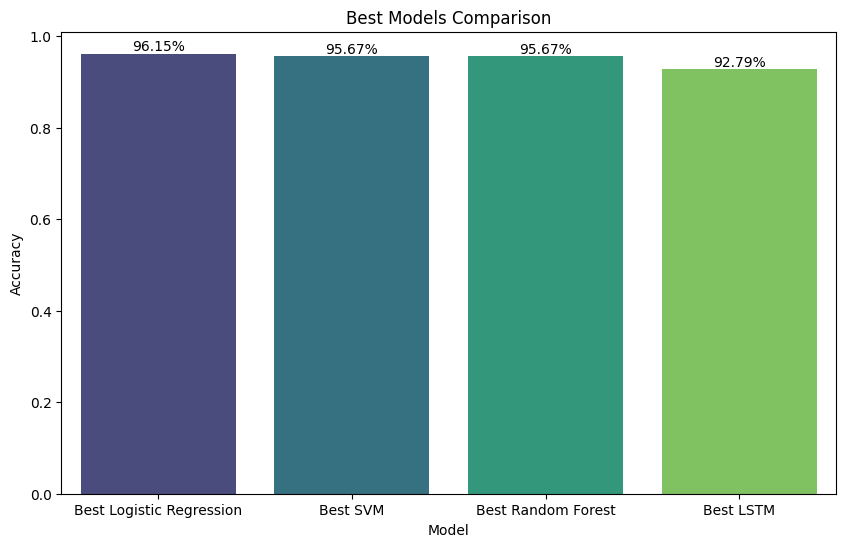

The best model overall is Best Logistic Regression with an accuracy of 96.15%


In [22]:
# Compare best models from each algorithm
best_models_results = {
    'Best Logistic Regression': log_reg_best_acc,
    'Best SVM': svm_best_acc,
    'Best Random Forest': rf_best_acc,
    'Best LSTM': lstm_best_acc
}

best_models_df = pd.DataFrame.from_dict(best_models_results, orient='index', columns=['Accuracy'])

# Plot best models comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=best_models_df.index, y='Accuracy', data=best_models_df, palette='viridis')
plt.title('Best Models Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for index, value in enumerate(best_models_df['Accuracy']):
    plt.text(index, value, f'{value*100:.2f}%', ha='center', va='bottom')
plt.show()

# Display the best model overall
best_model_overall = best_models_df['Accuracy'].idxmax()
print(f"The best model overall is {best_model_overall} with an accuracy of {best_models_results[best_model_overall]*100:.2f}%")

In [24]:
# Aspect-Based Sentiment Analysis
from nltk.tokenize import sent_tokenize

def aspect_sentiment_analysis(text):
    aspects = ["product quality", "shipping", "customer service"]  # Define aspects
    aspect_sentiments = {aspect: [] for aspect in aspects}

    sentences = sent_tokenize(text)
    for sentence in sentences:
        for aspect in aspects:
            if aspect in sentence:
                aspect_sentiments[aspect].append(get_sentiment(sentence))

    aspect_scores = {aspect: sum(scores) / len(scores) if scores else 0 for aspect, scores in aspect_sentiments.items()}
    return aspect_scores

df_2021['aspect_sentiments'] = df_2021['reviewText'].apply(aspect_sentiment_analysis)
df_2023['aspect_sentiments'] = df_2023['reviewText'].apply(aspect_sentiment_analysis)

# Interactive Sentiment Correlation Analysis
import plotly.express as px

def interactive_correlation_analysis(df):
    fig = px.scatter_matrix(
        df[['overall', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound', 'review_length', 'sentiment']],
        dimensions=['overall', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound', 'review_length', 'sentiment'],
        color='sentiment', title='Interactive Correlation Analysis',
        height=1200, width=2400  # Increased plot size
    )
    fig.update_traces(marker=dict(size=6, opacity=0.5))  # Smaller, more transparent markers
    fig.update_layout(font=dict(size=9))  # Smaller font size for axis ticks
    fig.update_xaxes(tickangle=45)  # Rotate x-axis labels for better fit
    fig.show()

interactive_correlation_analysis(df_2021)
interactive_correlation_analysis(df_2023)


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords

# Load datasets
df_2021 = pd.read_csv("amazon_reviews_2021.csv")
df_2023 = pd.read_csv("amazon_reviews_2023.csv")

# Function to perform aspect-based sentiment analysis
def aspect_sentiment_analysis(text):
    # Define aspects (you can extend this list based on your domain)
    aspects = ['quality', 'price', 'performance', 'customer service', 'shipping']
    aspect_sentiments = {aspect: [] for aspect in aspects}

    for aspect in aspects:
        if aspect in text:
            sentiment = TextBlob(text).sentiment.polarity
            aspect_sentiments[aspect].append(sentiment)

    return aspect_sentiments

# Apply aspect-based sentiment analysis to reviews
df_2021['aspect_sentiments'] = df_2021['reviewText'].apply(aspect_sentiment_analysis)
df_2023['aspect_sentiments'] = df_2023['reviewText'].apply(aspect_sentiment_analysis)

df_2021.head()

df_2023.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,aspect_sentiments
0,0,MacInTX,5,The card works with a Galaxy Note 2. Install ...,03/25/2023,473,28,15,43,13,2.711900,2.537360,"{'quality': [], 'price': [], 'performance': []..."
1,1,Michael A. Davis,1,When you are looking for a high end SD card wi...,12/11/2023,819,43,47,90,-4,2.352911,2.358947,"{'quality': [], 'price': [], 'performance': []..."
2,2,"Black Eyes ""Frosed""",3,What a bargain! 64GB of memory for all of you...,05/13/2023,822,35,33,68,2,3.494853,3.040944,"{'quality': [], 'price': [], 'performance': []..."
3,3,David McCutcheon,3,I made sure to get the one in the retail packa...,11/01/2023,907,43,21,64,22,0.515975,2.592850,"{'quality': [], 'price': [], 'performance': []..."
4,4,Joshua J. Wagner,1,To be the man you gotta beat the man brotha. A...,04/26/2023,108,38,48,86,-10,1.326933,2.231435,"{'quality': [], 'price': [0.5], 'performance':..."
